In [10]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from tensorflow.contrib import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import lightgbm as lgb
import catboost as cb

from PIL import Image

import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def lrelu(x,alpha=0.1):
    return tf.maximum(alpha*x,x)

In [5]:
#constants
learning_rate = 0.1
training_epoch = 100
batch_size = 100

###### 데이터 로드

In [7]:
root_path = 'C:/Workspace/DataChallenge/img/image_train/'

In [17]:
onlyfiles = [f for f in os.listdir(root_path) if os.path.isfile(os.path.join(root_path, f))]
image_array = np.zeros((len(onlyfiles), 28, 28))

count = 0
for i in onlyfiles :
    a = np.asarray(Image.open(root_path + i))
    image_array[count] = a
    count = count + 1

In [21]:
image_array = image_array.reshape(-1, 28, 28, 1)

In [4]:
x_data = pd.read_csv('../DataChallenge_/result_train/feature_asm_img.csv')[['hash'] + ['asm_img_' + str(i + 1) for i in range(28*28)]]

In [5]:
x_data = x_data.set_index('hash')

In [6]:
# for col in x_data:
#     x_data[col] = (x_data[col] - x_data[col].mean()) / x_data[col].std()

In [7]:
x_data = x_data.fillna(0)

In [8]:
x_data = x_data.astype(float)

In [9]:
x_data = x_data.values

In [10]:
x_data = x_data.reshape((-1,28,28,1))

In [11]:
X = tf.placeholder(tf.float32, [None, 28,28,1])
Y = tf.placeholder(tf.float32, [None, 28,28,1])
keep_prob = tf.placeholder(tf.float32)

In [12]:
#Encoder
with tf.name_scope('en-convolutions'):
    conv1 = tf.layers.conv2d(X,filters=32,kernel_size=(3,3),strides=(1,1),padding='SAME',use_bias=True,activation=lrelu,name='conv1')
# Now 10x10x32
 
with tf.name_scope('en-pooling'):
    maxpool1 = tf.layers.max_pooling2d(conv1,pool_size=(2,2),strides=(2,2),name='pool1')
    print(maxpool1.shape)
# Now 5x5x32
 
with tf.name_scope('en-convolutions'):
    conv2 = tf.layers.conv2d(maxpool1,filters=32,kernel_size=(3,3),strides=(1,1),padding='SAME',use_bias=True,activation=lrelu,name='conv2')
    print(conv2.shape)
# Now 5x5x32
 
with tf.name_scope('encoding'):
    encoded = tf.layers.max_pooling2d(conv2,pool_size=(2,2),strides=(2,2),name='encoding')
    print(encoded.shape)
# Now 2x2x32.

(?, 14, 14, 32)
(?, 14, 14, 32)
(?, 7, 7, 32)


In [13]:
#Decoder
with tf.name_scope('decoder'):
    conv3 = tf.layers.conv2d(encoded,filters=32,kernel_size=(3,3),strides=(1,1),name='conv3',padding='SAME',use_bias=True,activation=lrelu)
#Now 3x3x32 
    print(conv3.shape)
 
    upsample1 = tf.layers.conv2d_transpose(conv3,filters=32,kernel_size=3,padding='same',strides=2,name='upsample1')
# Now 6x6x32
 
    upsample2 = tf.layers.conv2d_transpose(upsample1,filters=32,kernel_size=3,padding='same',strides=2,name='upsample2')
# Now 12x12x32
 
    logits = tf.layers.conv2d(upsample2,filters=1,kernel_size=(3,3),strides=(1,1),name='logits',padding='SAME',use_bias=True)
#Now 28x28x1
 
# Pass logits through sigmoid to get denoisy image
    decoded = tf.sigmoid(logits,name='recon')

(?, 7, 7, 32)


Training data shape (9975, 28, 28, 1)
Testing data shape (9975, 28, 28, 1)


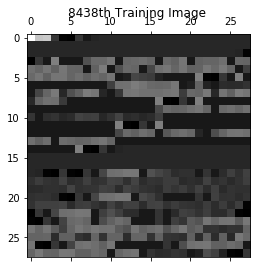

In [15]:
print('Training data shape', x_data.shape)
print('Testing data shape', x_data.shape)
 
nsample = 1
rand_train_idx = np.random.randint(x_data.shape[0], size=nsample)
 
for i in rand_train_idx:
    curr_img = np.reshape(x_data[i, :], (28,28))
    plt.matshow(curr_img, cmap=plt.get_cmap('gray'))
    plt.title(""+str(i)+"th Training Image ")
    plt.show()

In [16]:
#cost function
cost = tf.square(Y - logits)
cost = tf.reduce_mean(cost)

In [17]:
train = tf.train.AdadeltaOptimizer(learning_rate).minimize(cost)

In [19]:
cost_list = []
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(training_epoch):
    avg_cost = 0
    total_batch = int(10000 / batch_size)

    for i in range(total_batch):
        try:
            batch_x = x_data[i * batch_size: (i+1) * batch_size]
            batch_y = x_data[i * batch_size: (i+1) * batch_size]
        except:
            batch_x = x_data[i * batch_size:]
            batch_y = x_data[i * batch_size:]

        cost_val, _ = sess.run([cost, train], feed_dict={X:batch_x,Y:batch_y, keep_prob:0.7})
        avg_cost += cost_val/total_batch


#         print(sess.run([logits], feed_dict={X:x_data, Y:x_data}))
    print("[epoch : {}]  cost {}".format(epoch, avg_cost))
    cost_list.append(avg_cost)

[epoch : 0]  cost 2189.849094238282
[epoch : 1]  cost 782.291202392578
[epoch : 2]  cost 564.245849304199
[epoch : 3]  cost 375.4323818969726
[epoch : 4]  cost 281.86352264404303
[epoch : 5]  cost 227.11497711181636
[epoch : 6]  cost 192.886762084961
[epoch : 7]  cost 167.20990539550777
[epoch : 8]  cost 149.6274542236328
[epoch : 9]  cost 135.74511184692383
[epoch : 10]  cost 125.03015167236329
[epoch : 11]  cost 116.88793792724609
[epoch : 12]  cost 110.04764381408692
[epoch : 13]  cost 104.4400253295898
[epoch : 14]  cost 99.8464043426514
[epoch : 15]  cost 95.79859649658205
[epoch : 16]  cost 92.09034286499029
[epoch : 17]  cost 89.24765937805176
[epoch : 18]  cost 86.99378711700437
[epoch : 19]  cost 84.22846050262454
[epoch : 20]  cost 82.4196216964722
[epoch : 21]  cost 80.86054058074944
[epoch : 22]  cost 77.3874263763428
[epoch : 23]  cost 75.95737564086915
[epoch : 24]  cost 74.68870761871338
[epoch : 25]  cost 71.6529242706299
[epoch : 26]  cost 71.28551460266114
[epoch : 27

In [416]:
data_train = pd.read_csv('../DataChallenge_/data_train.csv').sort_values('hash')

data_asm_img = pd.read_csv('../DataChallenge_/result_train/feature_asm_img.csv')[['hash'] + ['asm_img_' + str(i + 1) for i in range(28*28)]].sort_values('hash')
label_train = data_asm_img['hash'].to_frame()
data_asm_img = data_asm_img.drop(['hash'], axis = 1)

t = sess.run([encoded], feed_dict={X:data_asm_img.values.reshape(-1, 28, 28, 1)})

t = np.squeeze(t).reshape((-1, 7*7*32))

for i in range(1568):
    label_train['ae_' + str(i)] = t[:, i]

data_train = pd.merge(data_train, label_train, on='hash', how='left').fillna(-99)

In [417]:
data_yesun = pd.read_csv('../DataChallenge_/data_yesun.csv').sort_values('hash')

data_asm_img = pd.read_csv('../DataChallenge_/result_yesun/feature_asm_img.csv')[['hash'] + ['asm_img_' + str(i + 1) for i in range(28*28)]].sort_values('hash')
label_yesun = data_asm_img['hash'].to_frame()
data_asm_img = data_asm_img.drop(['hash'], axis = 1)

t = sess.run([encoded], feed_dict={X:data_asm_img.values.reshape(-1, 28, 28, 1)})

t = np.squeeze(t).reshape((-1, 7*7*32))

for i in range(1568):
    label_yesun['ae_' + str(i)] = t[:, i]

data_yesun = pd.merge(data_yesun, label_yesun, on='hash', how='left').fillna(-99)

In [420]:
label_train.set_index('hash').to_csv('ae_train.csv')

In [421]:
label_yesun.set_index('hash').to_csv('ae_yesun.csv')

In [198]:
y_data_train = pd.read_excel('../DataChallenge_/result_train/label.xlsx').sort_values(by='hash')
label_train = y_data_train['hash'].to_frame()
is_mal_train = y_data_train['is_mal'].to_frame()

y_data_yesun = pd.read_excel('../DataChallenge_/result_yesun/label.xlsx').sort_values(by='hash')
label_yesun = y_data_yesun['hash'].to_frame()
is_mal_yesun = y_data_yesun['is_mal'].to_frame()

In [199]:
nineth = data_train.quantile([0.9])

In [193]:
data_train.loc[data_train['AddressOfEntryPoint'] > nineth['AddressOfEntryPoint'].values[0], 'AddressOfEntryPoint'] = nineth['AddressOfEntryPoint'].values[0]

In [188]:
# data_train.loc[data_train[data_train['AddressOfEntryPoint'] < nineth['AddressOfEntryPoint'].values[0]].index]['AddressOfEntryPoint'] = -99

In [200]:
for col in data_train:
    if col == 'hash':
        continue
    data_train.loc[data_train[col] > nineth[col].values[0], col] = nineth[col].values[0]

In [203]:
nineth = data_yesun.quantile([0.9])
# data_train.loc[data_train[data_train['AddressOfEntryPoint'] < nineth['AddressOfEntryPoint'].values[0]].index]['AddressOfEntryPoint'] = -99

for col in data_train:
    if col == 'hash':
        continue
    data_yesun.loc[data_yesun[col] > nineth[col].values[0], col] = nineth[col].values[0]

In [201]:
from sklearn.ensemble import RandomForestClassifier

In [355]:
rf = RandomForestClassifier(n_estimators=200, random_state=1, n_jobs=-1, max_depth=16, bootstrap=True)
rf.fit(data_train.drop(['hash'], axis = 1), is_mal_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [356]:
rf.score(data_train.drop(['hash'], axis = 1), is_mal_train)

0.9897

In [357]:
rf.score(data_yesun.drop(['hash'], axis = 1), is_mal_yesun)

0.9246

In [279]:
extree =  ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=70, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [280]:
extree.fit(data_train.drop(['hash'], axis = 1), is_mal_train)

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=70, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [281]:
extree.score(data_train.drop(['hash'], axis = 1), is_mal_train)

1.0

In [282]:
extree.score(data_yesun.drop(['hash'], axis = 1), is_mal_yesun)

0.9235

In [293]:
catboost = cb.CatBoostClassifier(depth=4, iterations=600, learning_rate=0.15, l2_leaf_reg=1)

In [294]:
catboost.fit(data_train.drop(['hash'], axis = 1), is_mal_train)

0:	learn: 0.6022512	total: 190ms	remaining: 1m 53s
1:	learn: 0.5243768	total: 326ms	remaining: 1m 37s
2:	learn: 0.4791035	total: 473ms	remaining: 1m 34s
3:	learn: 0.4366683	total: 624ms	remaining: 1m 33s
4:	learn: 0.4131440	total: 774ms	remaining: 1m 32s
5:	learn: 0.3947119	total: 914ms	remaining: 1m 30s
6:	learn: 0.3759339	total: 1.07s	remaining: 1m 30s
7:	learn: 0.3619842	total: 1.21s	remaining: 1m 29s
8:	learn: 0.3521103	total: 1.35s	remaining: 1m 28s
9:	learn: 0.3401209	total: 1.49s	remaining: 1m 28s
10:	learn: 0.3301338	total: 1.64s	remaining: 1m 27s
11:	learn: 0.3223377	total: 1.77s	remaining: 1m 26s
12:	learn: 0.3148808	total: 1.93s	remaining: 1m 27s
13:	learn: 0.3081141	total: 2.08s	remaining: 1m 27s
14:	learn: 0.3023762	total: 2.23s	remaining: 1m 26s
15:	learn: 0.2964141	total: 2.37s	remaining: 1m 26s
16:	learn: 0.2889295	total: 2.52s	remaining: 1m 26s
17:	learn: 0.2838311	total: 2.66s	remaining: 1m 26s
18:	learn: 0.2796823	total: 2.82s	remaining: 1m 26s
19:	learn: 0.2757285	t

157:	learn: 0.1399717	total: 25s	remaining: 1m 9s
158:	learn: 0.1397442	total: 25.2s	remaining: 1m 9s
159:	learn: 0.1396538	total: 25.3s	remaining: 1m 9s
160:	learn: 0.1393926	total: 25.5s	remaining: 1m 9s
161:	learn: 0.1391507	total: 25.6s	remaining: 1m 9s
162:	learn: 0.1387844	total: 25.8s	remaining: 1m 9s
163:	learn: 0.1385476	total: 26s	remaining: 1m 8s
164:	learn: 0.1379563	total: 26.1s	remaining: 1m 8s
165:	learn: 0.1372321	total: 26.3s	remaining: 1m 8s
166:	learn: 0.1370896	total: 26.5s	remaining: 1m 8s
167:	learn: 0.1369004	total: 26.6s	remaining: 1m 8s
168:	learn: 0.1366172	total: 26.8s	remaining: 1m 8s
169:	learn: 0.1363410	total: 26.9s	remaining: 1m 8s
170:	learn: 0.1362566	total: 27.1s	remaining: 1m 7s
171:	learn: 0.1359699	total: 27.3s	remaining: 1m 7s
172:	learn: 0.1355841	total: 27.4s	remaining: 1m 7s
173:	learn: 0.1353119	total: 27.6s	remaining: 1m 7s
174:	learn: 0.1349719	total: 27.7s	remaining: 1m 7s
175:	learn: 0.1349059	total: 27.9s	remaining: 1m 7s
176:	learn: 0.13

317:	learn: 0.1014022	total: 51.3s	remaining: 45.5s
318:	learn: 0.1013784	total: 51.4s	remaining: 45.3s
319:	learn: 0.1008695	total: 51.6s	remaining: 45.2s
320:	learn: 0.1006495	total: 51.8s	remaining: 45s
321:	learn: 0.1004973	total: 51.9s	remaining: 44.8s
322:	learn: 0.1004102	total: 52.1s	remaining: 44.7s
323:	learn: 0.1002921	total: 52.3s	remaining: 44.5s
324:	learn: 0.1002495	total: 52.4s	remaining: 44.3s
325:	learn: 0.1000604	total: 52.6s	remaining: 44.2s
326:	learn: 0.0998091	total: 52.7s	remaining: 44s
327:	learn: 0.0995148	total: 52.9s	remaining: 43.9s
328:	learn: 0.0994586	total: 53s	remaining: 43.7s
329:	learn: 0.0993406	total: 53.2s	remaining: 43.5s
330:	learn: 0.0990190	total: 53.4s	remaining: 43.4s
331:	learn: 0.0987410	total: 53.6s	remaining: 43.2s
332:	learn: 0.0985596	total: 53.7s	remaining: 43.1s
333:	learn: 0.0984735	total: 53.9s	remaining: 42.9s
334:	learn: 0.0983665	total: 54s	remaining: 42.7s
335:	learn: 0.0983665	total: 54.1s	remaining: 42.5s
336:	learn: 0.098229

476:	learn: 0.0830767	total: 1m 16s	remaining: 19.6s
477:	learn: 0.0829505	total: 1m 16s	remaining: 19.5s
478:	learn: 0.0828704	total: 1m 16s	remaining: 19.3s
479:	learn: 0.0828548	total: 1m 16s	remaining: 19.2s
480:	learn: 0.0827017	total: 1m 16s	remaining: 19s
481:	learn: 0.0826311	total: 1m 16s	remaining: 18.9s
482:	learn: 0.0826264	total: 1m 17s	remaining: 18.7s
483:	learn: 0.0825630	total: 1m 17s	remaining: 18.5s
484:	learn: 0.0825630	total: 1m 17s	remaining: 18.4s
485:	learn: 0.0824964	total: 1m 17s	remaining: 18.2s
486:	learn: 0.0824330	total: 1m 17s	remaining: 18s
487:	learn: 0.0823281	total: 1m 17s	remaining: 17.9s
488:	learn: 0.0823045	total: 1m 18s	remaining: 17.7s
489:	learn: 0.0821560	total: 1m 18s	remaining: 17.6s
490:	learn: 0.0821151	total: 1m 18s	remaining: 17.4s
491:	learn: 0.0820698	total: 1m 18s	remaining: 17.2s
492:	learn: 0.0817200	total: 1m 18s	remaining: 17.1s
493:	learn: 0.0816050	total: 1m 18s	remaining: 16.9s
494:	learn: 0.0816050	total: 1m 18s	remaining: 16.

In [295]:
catboost.score(data_train.drop(['hash'], axis = 1), is_mal_train)

0.9874

In [296]:
catboost.score(data_yesun.drop(['hash'], axis = 1), is_mal_yesun)

0.9309

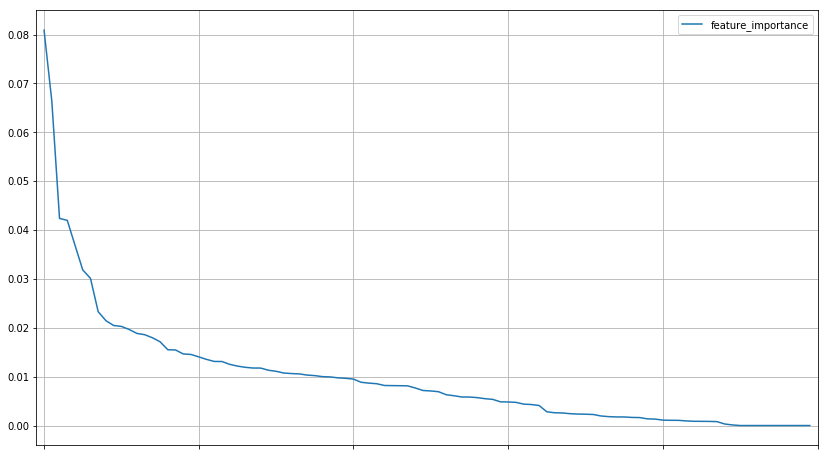

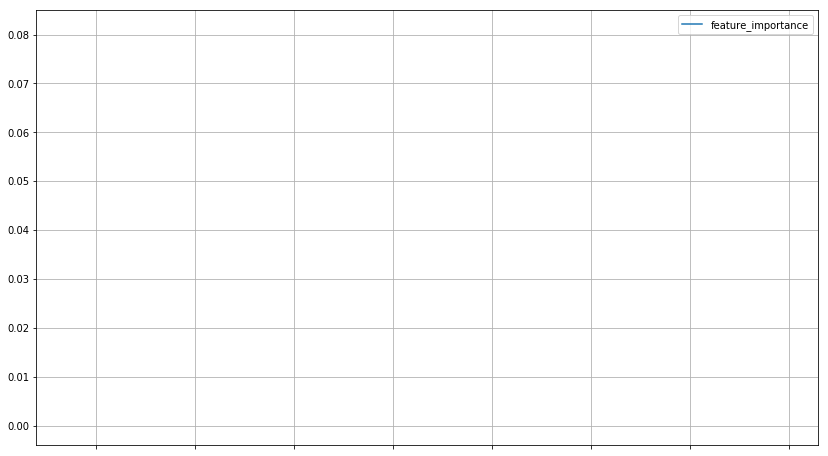

In [409]:
values = np.array([list(v) for v in sorted(zip(data_train.drop(['hash'], axis = 1).columns, rf.feature_importances_), key=lambda x: x[1] * -1)])
imp = pd.DataFrame(values[:,1], index = values[:,0], columns=["feature_importance"])
imp.feature_importance = imp.feature_importance.astype(float)

num = 100
imp.plot(figsize=(14,8), grid=True, xlim=(-1,num))
imp.plot(figsize=(14,8), grid=True, xlim=(num,len(data_train.drop(['hash'], axis = 1).columns)))

In [411]:
for v in imp.index:
    print(v)

MajorOperatingSystemVersion
SizeOfUninitializedData
MinorSubsystemVersion
DebugSize
EntropyMax
Characteristics
CheckSum
ax
SizeOfInitializedData
bl
GeneratedCheckSum
ebp
ecx
bh
NumberOfSections
ch
AddressOfEntryPoint
bx
eax
EntropyStd
SizeOfHeapReserve
retn
PeExe
SectionCnt
ah
pop
PeDriver
gs
esp_x
Machine
SizeOfHeapCommit
FunctionStatic
EntropyMoreThan7Cnt
PeDll
ExportSize
FunctionLibCnt
xor
SizeOfHeaders
MinorLinkerVersion
SizeOfImage
edi
SectionExecutionSizeMax
SectionExecutionSizeMin
cx
IatRva
al
si
cs
MajorLinkerVersion
cl
SectionSizeMean
SizeOfOptionalHeader
fs
SectionExecutionSizeMean
MinorOperatingSystemVersion
mov
SizeOfStackCommit
EntropyMean
dl
SectionSizeMin
ds
MajorImageVersion
FunctionCnt
edx
test
add_x
TimeDateStamp
esi_x
push
SectionWriteCnt
dh
FileAlignment
jmp
SizeOfStackReserve
call_x
FunctionHidden
es
SectionExecutableCnt
jnz
FunctionThunk
PointerToSymbolTable
sub_x
dx
SectionSizeSum
MinorImageVersion
ImageBase
TotalSizePE
SizeOfCode
MajorSubsystemVersion
di
NumberO

In [412]:
x_data_t = data_train[imp.index[:num]]

rf = RandomForestClassifier(n_estimators=200, random_state=1, n_jobs=-1, max_depth=28, bootstrap=True)
rf.fit(x_data_t, is_mal_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=28, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [413]:

rf.score(x_data_t, is_mal_train)


1.0

In [414]:

rf.score(data_yesun[imp.index[:num]], is_mal_yesun)

0.9503

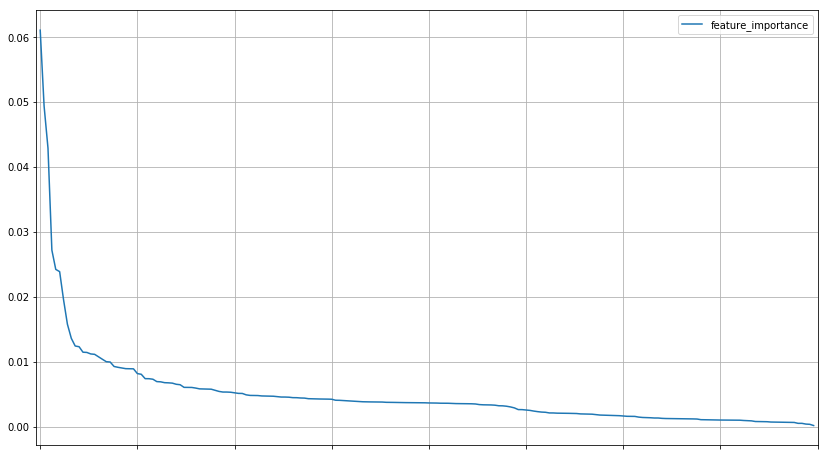

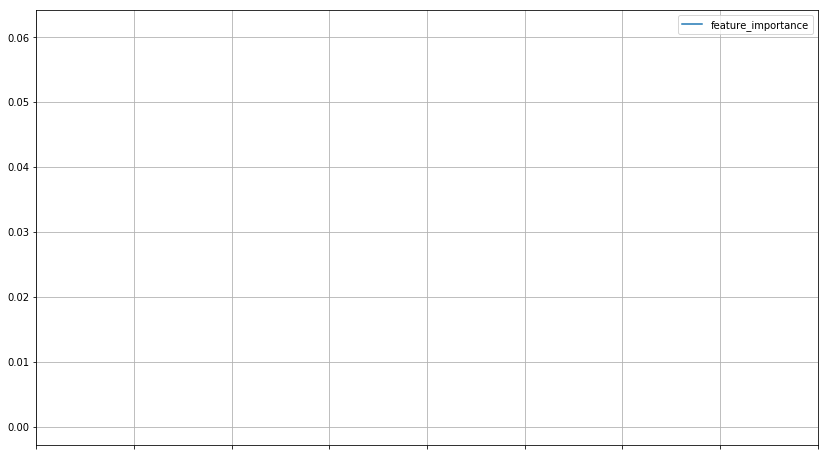

In [398]:
values = np.array([list(v) for v in sorted(zip(x_data_t.columns, rf.feature_importances_), key=lambda x: x[1] * -1)])
imp = pd.DataFrame(values[:,1], index = values[:,0], columns=["feature_importance"])
imp.feature_importance = imp.feature_importance.astype(float)

num = 200
imp.plot(figsize=(14,8), grid=True, xlim=(-1,num))
imp.plot(figsize=(14,8), grid=True, xlim=(num,len(x_data_t.columns)))

In [400]:
for v in imp.index:
    print(v)

PeDll
ImageBase
PeExe
ExportSize
Characteristics
EntropyMax
CheckSum
call_x
SectionSizeSum
TotalSizePE
TimeDateStamp
malloc
EntropyStd
SectionSizeMean
GeneratedCheckSum
MajorOperatingSystemVersion
FunctionLibCnt
pop
FunctionCnt
DebugSize
AddressOfEntryPoint
EntropyMoreThan7Cnt
MajorLinkerVersion
EntropyMean
SizeOfImage
SectionSizeMax
test
esi_x
edi
jz_y
jnz
FunctionHidden
dd_y
dw_y
ebx
add_x
jz_x
MajorSubsystemVersion
SizeOfCode
ebp
SectionExecutionSizeMin
alloc
MajorImageVersion
retn
SectionSizeMin
ecx
db_y
IatRva
xchg
movzx
mov
xor
SectionWriteCnt
esp_x
jle
ch
edx
ae_1537
lea_x
push
ae_1395
SectionExecutionSizeMean
eax
SizeOfInitializedData
jmp
not
ax
FunctionThunk
public
bh
ae_1401
cx
ae_1523
ah
neg
dl
ae_1389
sub_x
proc
ae_1427
ae_1369
inc_x
dh
bl
ae_1371
microsoft
SectionCnt
dec_x
ae_1376
ae_1405
free
windows
ae_1406
ae_1399
ae_1187
ae_1531
and
ae_1382
ae_1437
cl
ae_1423
rol
al
SectionExecutionSizeMax
ae_1377
NumberOfSections
ae_1461
leave
ae_1483
FunctionStatic
ae_1409
ae_1556
ae

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from tensorflow.contrib import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import lightgbm as lgb
import catboost as cb

In [2]:
#constants
learning_rate = 0.00001
training_epoch = 30
batch_size = 100

In [3]:
x_train = pd.read_csv('./ae_train.csv').sort_values('hash')#.drop(['hash'], axis = 1).values
y_train = pd.read_excel('../DataChallenge_/result_train/label.xlsx').sort_values(by='hash')#.drop(['hash'], axis = 1).values
x_data = pd.merge(y_train, x_train, on='hash', how='left')
x_train = x_data.drop(['hash', 'is_mal'], axis = 1).fillna(0)
y_train = x_data['is_mal'].to_frame()

x_test = pd.read_csv('./ae_yesun.csv').sort_values('hash')#.drop(['hash'], axis = 1).values
y_test = pd.read_excel('../DataChallenge_/result_yesun/label.xlsx').sort_values(by='hash')#.drop(['hash'], axis = 1).values
x_data = pd.merge(y_test, x_test, on='hash', how='left')
x_test = x_data.drop(['hash', 'is_mal'], axis = 1).fillna(0)
y_test = x_data['is_mal'].to_frame()

In [27]:
nineth = x_train.quantile([0.9])
# data_train.loc[data_train[data_train['AddressOfEntryPoint'] < nineth['AddressOfEntryPoint'].values[0]].index]['AddressOfEntryPoint'] = -99

for col in x_train:
    if col == 'hash':
        continue
    x_train.loc[x_train[col] > nineth[col].values[0], col] = nineth[col].values[0]
    
    x_train[col] = (x_train[col] - x_train[col].mean()) / x_train[col].std()

AttributeError: 'numpy.ndarray' object has no attribute 'quantile'

In [19]:
x_train = x_train.values
y_train = y_train.values

In [12]:
nineth = x_test.quantile([0.9])
# data_train.loc[data_train[data_train['AddressOfEntryPoint'] < nineth['AddressOfEntryPoint'].values[0]].index]['AddressOfEntryPoint'] = -99

for col in x_test:
    if col == 'hash':
        continue
    x_test.loc[x_test[col] > nineth[col].values[0], col] = nineth[col].values[0]
    
    x_test[col] = (x_test[col] - x_test[col].mean()) / x_test[col].std()

In [6]:
X = tf.placeholder(tf.float32, [None, 1568])
Y = tf.placeholder(tf.float32, [None, 1])
keep_prob = tf.placeholder(tf.float32)

In [7]:
#layer1
with tf.name_scope("layer1") as scope:
    W1 = tf.get_variable("W1", [1568, 1024], tf.float32, layers.xavier_initializer())
    b1 = tf.Variable(tf.random_normal([1024]), name="bias1")

    layer1 = tf.nn.relu(tf.matmul(X, W1) + b1)
    layer1 = tf.nn.dropout(layer1, keep_prob)

#layer2
with tf.name_scope("layer2") as scope:
    W2 = tf.get_variable("W2", [1024,512], tf.float32, layers.xavier_initializer())
    b2 = tf.Variable(tf.random_normal([512]), name="bias2")

    layer2 = tf.nn.relu(tf.matmul(layer1, W2) + b2)
    layer2 = tf.nn.dropout(layer2, keep_prob)

#layer3
with tf.name_scope("layer3") as scope:
    W3 = tf.get_variable("W3", [512,256], tf.float32, layers.xavier_initializer())
    b3 = tf.Variable(tf.random_normal([256]), name="bias3")

    layer3 = tf.nn.relu(tf.matmul(layer2, W3) + b3)
    layer3 = tf.nn.dropout(layer3, keep_prob)

#layer4
with tf.name_scope("layer4") as scope:
    W4 = tf.get_variable("W4", [256,128], tf.float32, layers.xavier_initializer())
    b4 = tf.Variable(tf.random_normal([128]), name="bias4")

    layer4 = tf.nn.relu(tf.matmul(layer3, W4) + b4)
    layer4 = tf.nn.dropout(layer4, keep_prob)

#layer5
with tf.name_scope("layer5") as scope:
    W5 = tf.get_variable("W5", [128,64], tf.float32, layers.xavier_initializer())
    b5 = tf.Variable(tf.random_normal([64]), name="bias5")

    layer5 = tf.nn.relu(tf.matmul(layer4, W5) + b5)
    layer5 = tf.nn.dropout(layer5, keep_prob)

#layer6
with tf.name_scope("layer6") as scope:
    W6 = tf.get_variable("W6", [64,32], tf.float32, layers.xavier_initializer())
    b6 = tf.Variable(tf.random_normal([32]), name="bias6")

    layer6 = tf.nn.relu(tf.matmul(layer5, W6) + b6)
    layer6 = tf.nn.dropout(layer6, keep_prob)

#layer7
with tf.name_scope("layer7") as scope:
    W7 = tf.get_variable("W7", [32,16], tf.float32, layers.xavier_initializer())
    b7 = tf.Variable(tf.random_normal([16]), name="bias7")

    layer7 = tf.nn.relu(tf.matmul(layer6, W7) + b7)
    layer7 = tf.nn.dropout(layer7, keep_prob)

#layer8
with tf.name_scope("layer8") as scope:
    W8 = tf.get_variable("W8", [16,8], tf.float32, layers.xavier_initializer())
    b8 = tf.Variable(tf.random_normal([8]), name="bias8")

    layer8 = tf.nn.relu(tf.matmul(layer7, W8) + b8)
    layer8 = tf.nn.dropout(layer8, keep_prob)

#hypothesis
with tf.name_scope("hypothesis") as scope:
    W9 = tf.get_variable("W9", [8,1], tf.float32, layers.xavier_initializer())
    b9 = tf.Variable(tf.random_normal([1]), name="bias9")

    logits = tf.nn.sigmoid(tf.matmul(layer8, W9) + b9)

In [16]:
#cost function
cost = tf.reduce_mean(tf.square(logits - Y), -1, name="cost")

train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

#verification
prediction = tf.argmax(logits, -1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(Y, -1)), tf.float32))

In [26]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print(sess.run([logits], feed_dict={X:x_train, Y:y_train, keep_prob:0.7}))
'''
    for epoch in range(training_epoch):
        avg_cost = 0
        total_batch = int(10000 / batch_size)

        for i in range(total_batch):
            try:
                batch_x = x_train[i * batch_size: (i+1) * batch_size]
                batch_y = y_train[i * batch_size: (i+1) * batch_size]
            except:
                batch_x = x_train[i * batch_size:]
                batch_y = y_train[i * batch_size:]
                
            cost_val, _ = sess.run([cost, train], feed_dict={X:batch_x,Y:batch_y, keep_prob:0.7})
            avg_cost += cost_val/total_batch
            
            print(cost_val)

        print("[epoch : {}]  cost {}".format(epoch, avg_cost))

#     print("accuracy : {}".format(sess.run(accuracy, feed_dict={X:x_test, Y:y_test, keep_prob:1})))
'''

[array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)]


'\n    for epoch in range(training_epoch):\n        avg_cost = 0\n        total_batch = int(10000 / batch_size)\n\n        for i in range(total_batch):\n            try:\n                batch_x = x_train[i * batch_size: (i+1) * batch_size]\n                batch_y = y_train[i * batch_size: (i+1) * batch_size]\n            except:\n                batch_x = x_train[i * batch_size:]\n                batch_y = y_train[i * batch_size:]\n                \n            cost_val, _ = sess.run([cost, train], feed_dict={X:batch_x,Y:batch_y, keep_prob:0.7})\n            avg_cost += cost_val/total_batch\n            \n            print(cost_val)\n\n        print("[epoch : {}]  cost {}".format(epoch, avg_cost))\n\n#     print("accuracy : {}".format(sess.run(accuracy, feed_dict={X:x_test, Y:y_test, keep_prob:1})))\n'